# MXNet の紹介<br><small>と、ライブデモ</small>

<p style="text-align:center;font-size:150%;line-height:150%">2016/02/06 Python東海 第29回勉強会<br>後藤 俊介 ( @antimon2 )</p>

## 自己紹介

+ 名前：後藤 俊介
+ 所属：株式会社コスモルート クラウドR&Dグループ 数学班
+ 言語：Ruby, JavaScript, Python, Julia, Haxe, …
+ twitter: [@antimon2](https://twitter.com/antimon2 "あんちもん2(@antimon2)さん | Twitter")
+ Facebook: [antimon2](https://www.facebook.com/antimon2 "後藤 俊介")
+ GitHub: [antimon2](https://github.com/antimon2/ "antimon2 (GOTOH Shunsuke)")

### 宣伝：機械学習 名古屋 勉強会

機械学習 名古屋 勉強会 主催（共催）してます！

[<img src="./MLNGY_connpass.jpg" width="512" />](http://machine-learning.connpass.com/ "機械学習　名古屋 - connpass")

## MXNet とは

+ サイト：http://mxnet.rtfd.org/
+ 「効率」と「柔軟性」を両立した Deep Learning フレームワーク。
+ **Python**, **Julia**, R, C++ に対応。

## MXNet のインストールと環境構築（概要）

（インストール詳細は [本家ドキュメント](http://mxnet.readthedocs.org/en/latest/build.html "Installation Guide &mdash; mxnet 0.5.0 documentation") を参照）

環境：
+ Mac OSX 10.10.x/10.11.x
+ Julia 0.4.3
+ Python 2.7.9/2.7.11 ＋ pyenv + pyenv-virtualenv

※ 以下の手順は、@antimon2 が動作テストのために行った仮の手順です。

### Julia に MXNet.jl をインストール

```bash
$ julia

julia> Pkg.update()

julia> Pkg.add("MXNet")

```

↑ ダイナミックリンクライブラリ libmxnet.so のビルドまでやってくれる。

### MXNet 用 Python 仮想環境作成

```bash
$ pyenv virtualenv 2.7.11 MXNet
$ pyenv shell MXNet
$ pyenv version
MXNet (set by PYENV_VERSION environment variable)
$ pip install -U pip
$ pip install -U numpy matplotlib jupyter
```

### Python パッケージインストール

```bash
$ cd ~/.julia/v0.4/MXNet/deps/src/mxnet/python
$ pyenv shell MXNet
$ pyenv version
MXNet (set by PYENV_VERSION environment variable)
$ python setup.py install
```

※ Julia パッケージインストール時に pull された git リポジトリをそのまま利用。

### Jupyter カーネル追加

```bash
$ pyenv shell MXNet
$ pyenv version
MXNet (set by PYENV_VERSION environment variable)
$ python -m ipykernel install --user --name mxnet --display-name "MXNet (Python 2)"
Installed kernelspec mxnet in [path/to/JUPYTER_DIR]/kernels/mxnet
```

### 動作確認

In [2]:
import mxnet as mx

OpenCV is unavailable.


In [3]:
import numpy as np

a = mx.nd.empty((2, 3))
a[:] = np.random.uniform(-0.1, 0.1, a.shape)
a.asnumpy()

array([[-0.01725694, -0.0075838 , -0.03712081],
       [-0.00217939,  0.07316095,  0.05397278]], dtype=float32)

## 3LP サンプル (MNIST)

※ 3LP：3 Layer Perceptron の略。Deep Learning のキホン。

### MNIST データ読込

In [ ]:
# このセルは1回だけ実行
import os

if not os.path.isdir("data/"):
    os.system("mkdir data/")
if (not os.path.exists('data/train-images-idx3-ubyte')) or \
   (not os.path.exists('data/train-labels-idx1-ubyte')) or \
   (not os.path.exists('data/t10k-images-idx3-ubyte')) or \
   (not os.path.exists('data/t10k-labels-idx1-ubyte')):
    os.system("wget http://webdocs.cs.ualberta.ca/~bx3/data/mnist.zip -P data/")
    os.chdir("./data")
    os.system("unzip -u mnist.zip")
    os.chdir("..")


In [ ]:
import mxnet as mx
import numpy as np

In [4]:
def mnist_iterator(batch_size, input_shape):
    """return train and val iterators for mnist"""
    # download data
    # get_data.GetMNIST_ubyte()
    flat = False if len(input_shape) == 3 else True

    train_dataiter = mx.io.MNISTIter(
        image="data/train-images-idx3-ubyte",
        label="data/train-labels-idx1-ubyte",
        input_shape=input_shape,
        batch_size=batch_size,
        shuffle=True,
        flat=flat)

    val_dataiter = mx.io.MNISTIter(
        image="data/t10k-images-idx3-ubyte",
        label="data/t10k-labels-idx1-ubyte",
        input_shape=input_shape,
        batch_size=batch_size,
        flat=flat)

    return (train_dataiter, val_dataiter)


In [5]:
train, val = mnist_iterator(batch_size=100, input_shape = (784,))

#### 確認

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

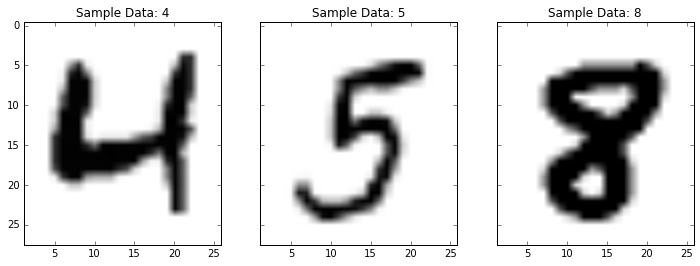

In [7]:
images = train.getdata().asnumpy()
labels = train.getlabel().asnumpy()
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
for i in range(3):
    image = np.reshape(images[i], [28, 28])
    axs[i].imshow(image, cmap=cm.Greys)
    axs[i].set_title("Sample Data: %d" % labels[i])

In [8]:
train.reset()

In [9]:
# define 3lp

data = mx.symbol.Variable('data')
fc1 = mx.symbol.FullyConnected(data = data, name='fc1', num_hidden=128)
act1 = mx.symbol.Activation(data = fc1, name='relu1', act_type="relu")
fc2 = mx.symbol.FullyConnected(data = act1, name = 'fc2', num_hidden = 64)
act2 = mx.symbol.Activation(data = fc2, name='relu2', act_type="relu")
fc3 = mx.symbol.FullyConnected(data = act2, name='fc3', num_hidden=10)
mlp = mx.symbol.SoftmaxOutput(data = fc3, name = 'softmax')

In [10]:
# train

model = mx.model.FeedForward(
    ctx = mx.cpu(), symbol = mlp, num_epoch = 20,
    learning_rate = 0.1, momentum = 0.9, wd = 0.00001)

model.fit(X=train, eval_data=val)

In [11]:
# predict

probs = model.predict(val)

In [12]:
# collect all labels from eval data
val.reset()
labels = np.concatenate(tuple(val.getlabel().asnumpy() for _ in val))

# Now we use compute the accuracy
correct = 0
for i in range(len(labels)):
    if np.argmax(probs[i,:]) == labels[i]:
        correct += 1

accuracy = 100.0 * correct / len(labels)
print("Accuracy on eval set: %.2f%%" % accuracy)

Accuracy on eval set: 97.60%


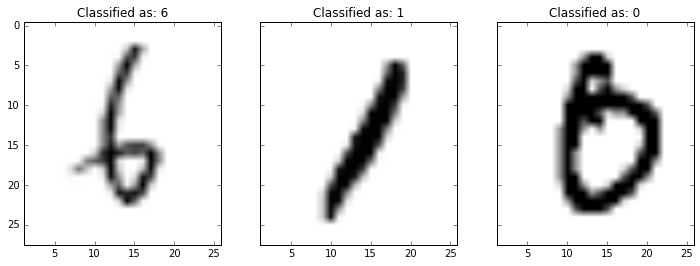

In [13]:
# show first-3 eval data
val.reset()
val.next()
images = val.getdata().asnumpy()

f, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

for i in range(3):
    image = np.reshape(images[i], [28, 28])
    axs[i].imshow(image, cmap=cm.Greys)
    axs[i].set_title("Classified as: %d" % np.argmax(probs[i, :]))

val.reset()

## 参考

+ [MXNet](http://mxnet.rtfd.org/ "MXNet Documentation &mdash; mxnet 0.5.0 documentation")
+ [MXNet.jl](https://github.com/dmlc/MXNet.jl "dmlc/MXNet.jl: MXNet Julia Package - flexible and efficient deep learning in Julia")
+ [Installing the IPython kernel](http://ipython.readthedocs.org/en/stable/install/kernel_install.html "Installing the IPython kernel &mdash; IPython 4.1.1 documentation")

## おしまい

ご清聴ありがとうございました。

In [1]:
from IPython.core.display import HTML
HTML(r"""<style>
.reveal>.state-background{background-color:#fcfcff}
.reveal .rendered_html pre,.reveal .rendered_html code{background-color:#eee}
</style>""")